In [1]:
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# ------------------------------------------------------
import statsmodels.api as sm

# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


In [2]:
# Import
train = pd.read_csv("data/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("data/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("data/store-sales-time-series-forecasting/stores.csv")
#sub = pd.read_csv("../input/store-sales-time-series-forecasting/sample_submission.csv")   
transactions = pd.read_csv("data/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])


# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

### About the dataset
The dataset originates from Corporación Favorita, a prominent grocery retailer based in Ecuador, which also has operations in several other South American countries.
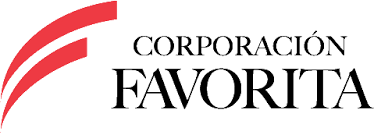

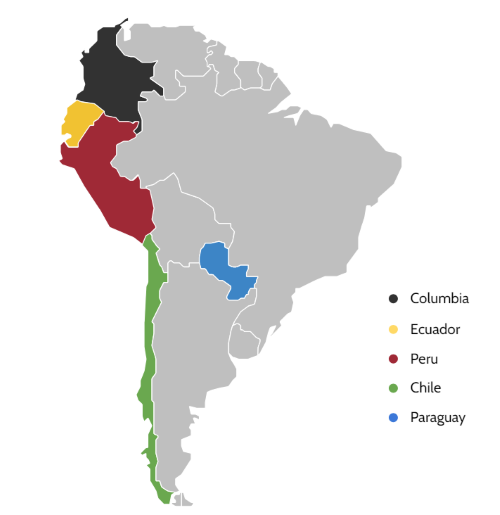

The time series spans from January 1, 2013, to August 31, 2017. Understanding the date range in the test data is crucial for devising a cross-validation strategy and developing new features.

In [3]:
transactions.head(10)

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520
231,2013-01-07,1,1807
277,2013-01-08,1,1869
323,2013-01-09,1,1910
369,2013-01-10,1,1679
415,2013-01-11,1,1813


In [4]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0.0
1,1,2013-01-01,1,BABY CARE,0.000000,0.0
2,2,2013-01-01,1,BEAUTY,0.000000,0.0
3,3,2013-01-01,1,BEVERAGES,0.000000,0.0
4,4,2013-01-01,1,BOOKS,0.000000,0.0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8.0


- <strong>Transactions data</strong> refer to the number of individuals who visited the store or the quantity of invoices generated within a day. 
The transactions data shows a strong correlation with the sales data in the training dataset, providing insight into the sales patterns of the stores.<br><br>


- <strong>Sales data</strong> represent the number of sales generated from a specific product category within a particular store on a specified date. It is important to note that fractional values are possible due to the products being sold in fractional units (such as 1.5 kg of cheese, rather than whole units like 1 bag of chips).

<Axes: >

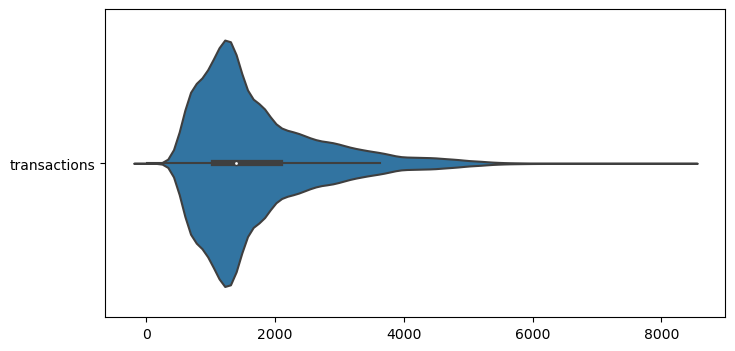

In [5]:
transac = pd.DataFrame(transactions['transactions'])
f = plt.figure(figsize=(8, 4))
sb.violinplot(data = transac, orient = "h")

we use a violin plot to visualize the distribution of the monthly average number of transactions from all stores from 2013 to 2017. We can see the monthly average number of transactions for a store is around 1694 transactions.

In [6]:
transac.describe()

,transactions
count,83488.000000
mean,1694.602158
std,963.286644
min,5.000000
25%,1046.000000
50%,1393.000000
75%,2079.000000
max,8359.000000


In [7]:
a = transactions.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year

#add a "month" column to the dataframe
sr = pd.to_datetime(a['date']) 
result = sr.dt.month_name(locale = 'English') 
a2 = a.assign(month=result)

In [8]:
#monthly average transactions for 2013
a2013 = a2.loc[a['year'] == 2013]
a2013

,date,transactions,year,month
0,2013-01-31,1657.898624,2013,January
1,2013-02-28,1684.483696,2013,February
2,2013-03-31,1724.181627,2013,March
3,2013-04-30,1699.206522,2013,April
4,2013-05-31,1702.874396,2013,May
5,2013-06-30,1701.426743,2013,June
6,2013-07-31,1675.012552,2013,July
7,2013-08-31,1689.182567,2013,August
8,2013-09-30,1688.270922,2013,September
9,2013-10-31,1653.013040,2013,October


In [9]:
#monthly average transactions for each year
a2014 = a2.loc[a['year'] == 2014]
a2015 = a2.loc[a['year'] == 2015]
a2016 = a2.loc[a['year'] == 2016]
a2017 = a2.loc[a['year'] == 2017]

### Number of monthly average transactions for each year
It seems that there is a pattern with the number of transactions increasing at the end of the year in  December.

<Axes: xlabel='month', ylabel='transactions'>

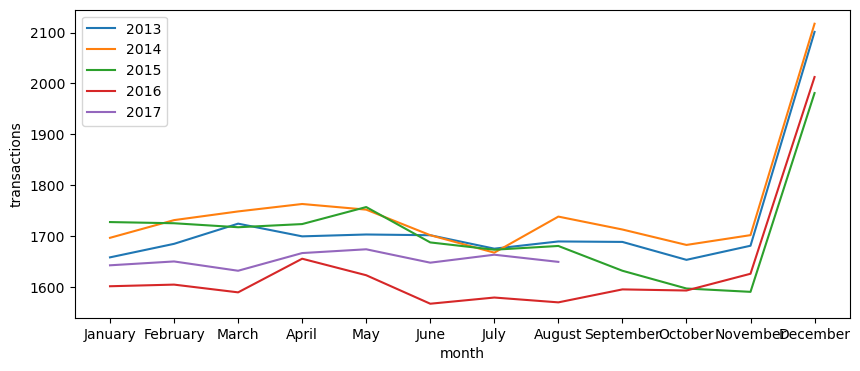

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
    
sb.lineplot(data=a2013, x="month", y="transactions", ax=ax, label="2013")
sb.lineplot(data=a2014, x="month", y="transactions", ax=ax, label="2014")
sb.lineplot(data=a2015, x="month", y="transactions", ax=ax, label="2015")
sb.lineplot(data=a2016, x="month", y="transactions", ax=ax, label="2016")
sb.lineplot(data=a2017, x="month", y="transactions", ax=ax, label="2017")

### Which day of the week has the most transactions on average?
The days of the week play a significant role in shopping behavior, revealing consistent patterns over the years 2013 to 2017. Stores experience higher transaction volumes on weekends, with Saturday emerging as the busiest shopping day throughout this period.
- This means most people are likely to go shopping on Saturday

In [11]:
a = transactions.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()

In [12]:
a2013 = a.loc[a['year'] == 2013]
a2014 = a.loc[a['year'] == 2014]
a2015 = a.loc[a['year'] == 2015]
a2016 = a.loc[a['year'] == 2016]
a2017 = a.loc[a['year'] == 2017]

<Axes: xlabel='dayofweek', ylabel='transactions'>

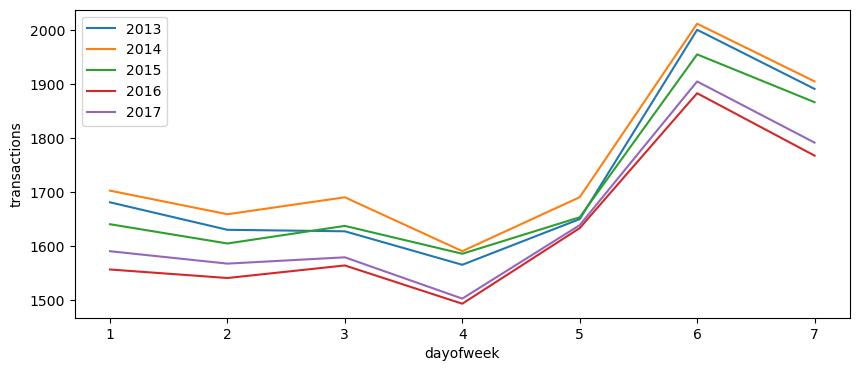

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
    
sb.lineplot(data=a2013, x="dayofweek", y="transactions", ax=ax, label="2013")
sb.lineplot(data=a2014, x="dayofweek", y="transactions", ax=ax, label="2014")
sb.lineplot(data=a2015, x="dayofweek", y="transactions", ax=ax, label="2015")
sb.lineplot(data=a2016, x="dayofweek", y="transactions", ax=ax, label="2016")
sb.lineplot(data=a2017, x="dayofweek", y="transactions", ax=ax, label="2017")

### Which product category sells the most items? 

The graph shows us GROCERY I, BEVERAGES, and PRODUCE are the top 3 selling categories among the grocery stores.

In [14]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0.0
1,1,2013-01-01,1,BABY CARE,0.000000,0.0
2,2,2013-01-01,1,BEAUTY,0.000000,0.0
3,3,2013-01-01,1,BEVERAGES,0.000000,0.0
4,4,2013-01-01,1,BOOKS,0.000000,0.0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8.0


<Axes: xlabel='sales', ylabel='family'>

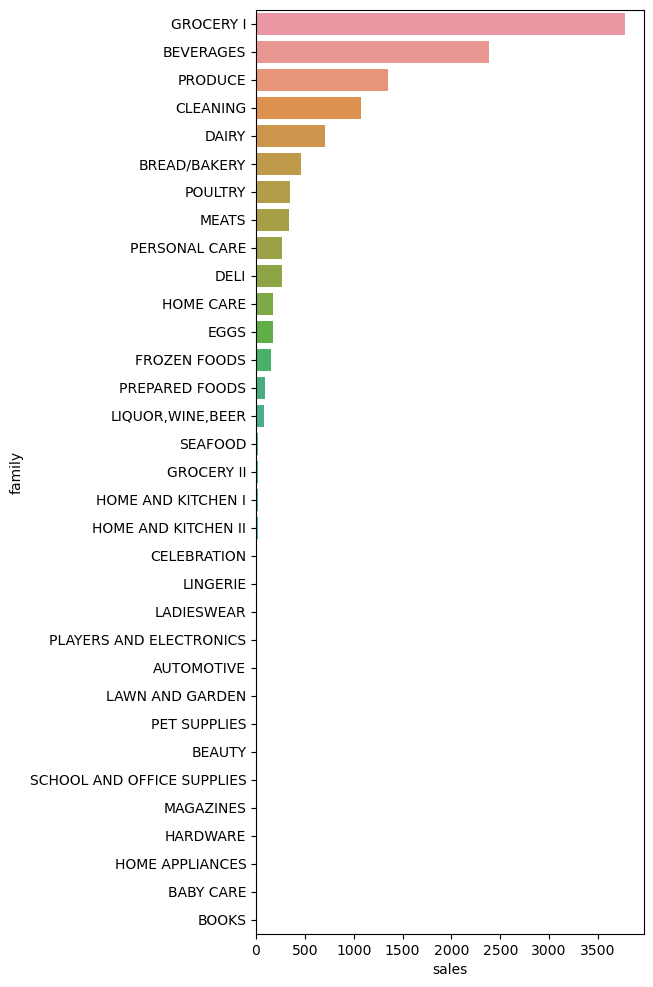

In [15]:
a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
a

fig, ax = plt.subplots(figsize=(5, 12))
sb.barplot(x=a.sales, y=a.family, orient='h')

### What is a Time Series?

The basic object of forecasting is the time series, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

In [16]:
def grouped(df, key, freq, col):
    #group data with certain frequency
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [17]:
df_grouped_train_w = grouped(train, 'date', 'W', 'sales')
df_grouped_train_w

,date,mean
0,2013-01-06,206.843475
1,2013-01-13,190.285217
2,2013-01-20,189.835464
3,2013-01-27,182.152054
4,2013-02-03,198.564270
...,...,...
237,2017-07-23,460.504639
238,2017-07-30,474.732391
239,2017-08-06,513.884338
240,2017-08-13,431.730164


In [18]:
df_grouped_train_w = df_grouped_train_w.set_index("date")
df = df_grouped_train_w.copy()
df['Time'] = np.arange(len(df_grouped_train_w.index))
df.head()

,mean,Time
date,,
2013-01-06,206.843475,0
2013-01-13,190.285217,1
2013-01-20,189.835464,2
2013-01-27,182.152054,3
2013-02-03,198.564270,4


In [19]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'mean']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

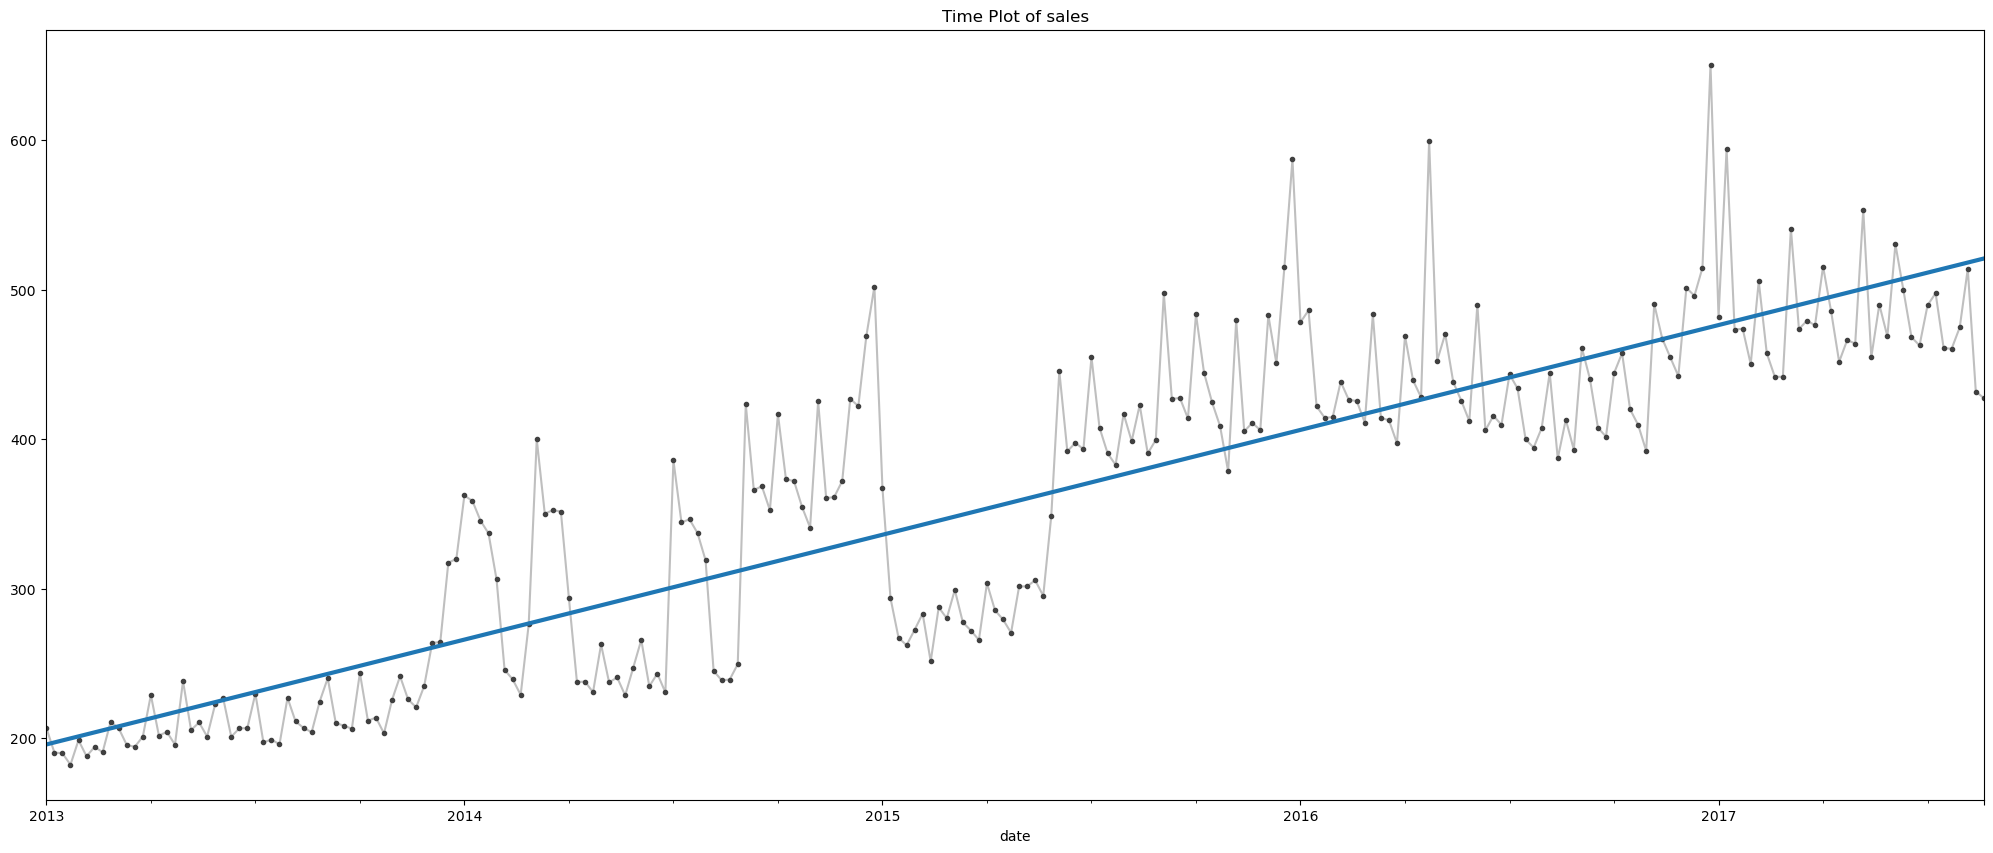

In [20]:
fig, axes = plt.subplots(figsize=(25,10))
ax = y.plot(color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of sales');

In [21]:
df_grouped = grouped(train, 'date', 'W', 'sales')
df_grouped

,date,mean
0,2013-01-06,206.843475
1,2013-01-13,190.285217
2,2013-01-20,189.835464
3,2013-01-27,182.152054
4,2013-02-03,198.564270
...,...,...
237,2017-07-23,460.504639
238,2017-07-30,474.732391
239,2017-08-06,513.884338
240,2017-08-13,431.730164


### What is Trend?
The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

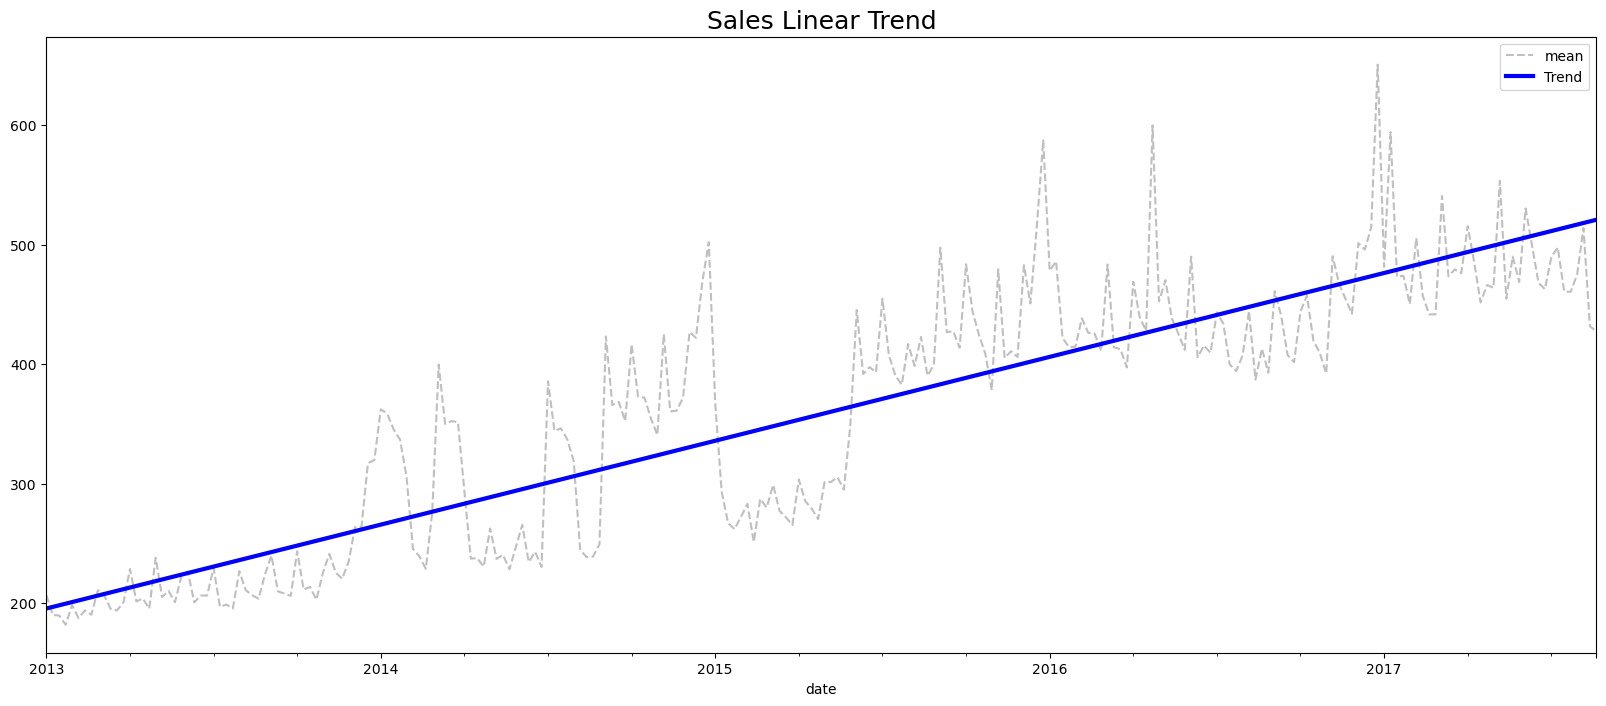

In [22]:
fig, axes = plt.subplots(figsize=(20,8))

df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d") 
dp = DeterministicProcess(index=df_grouped['date'], constant=True, order=1, drop=True)
dp.index.freq = 'W' # manually set the frequency of the index
# 'in_sample' creates features for the dates given in the `index` argument
X1 = dp.in_sample()
y1 = df_grouped["mean"]  # the target
y1.index = X1.index
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X1, y1)
y1_pred = pd.Series(model.predict(X1), index=X1.index)
ax1 = y1.plot(linestyle='dashed', label="mean", color="0.75")
ax1 = y1_pred.plot(linewidth=3, label="Trend", color='b')
ax1.set_title("Sales Linear Trend", fontsize=18)  
_ = ax1.legend()

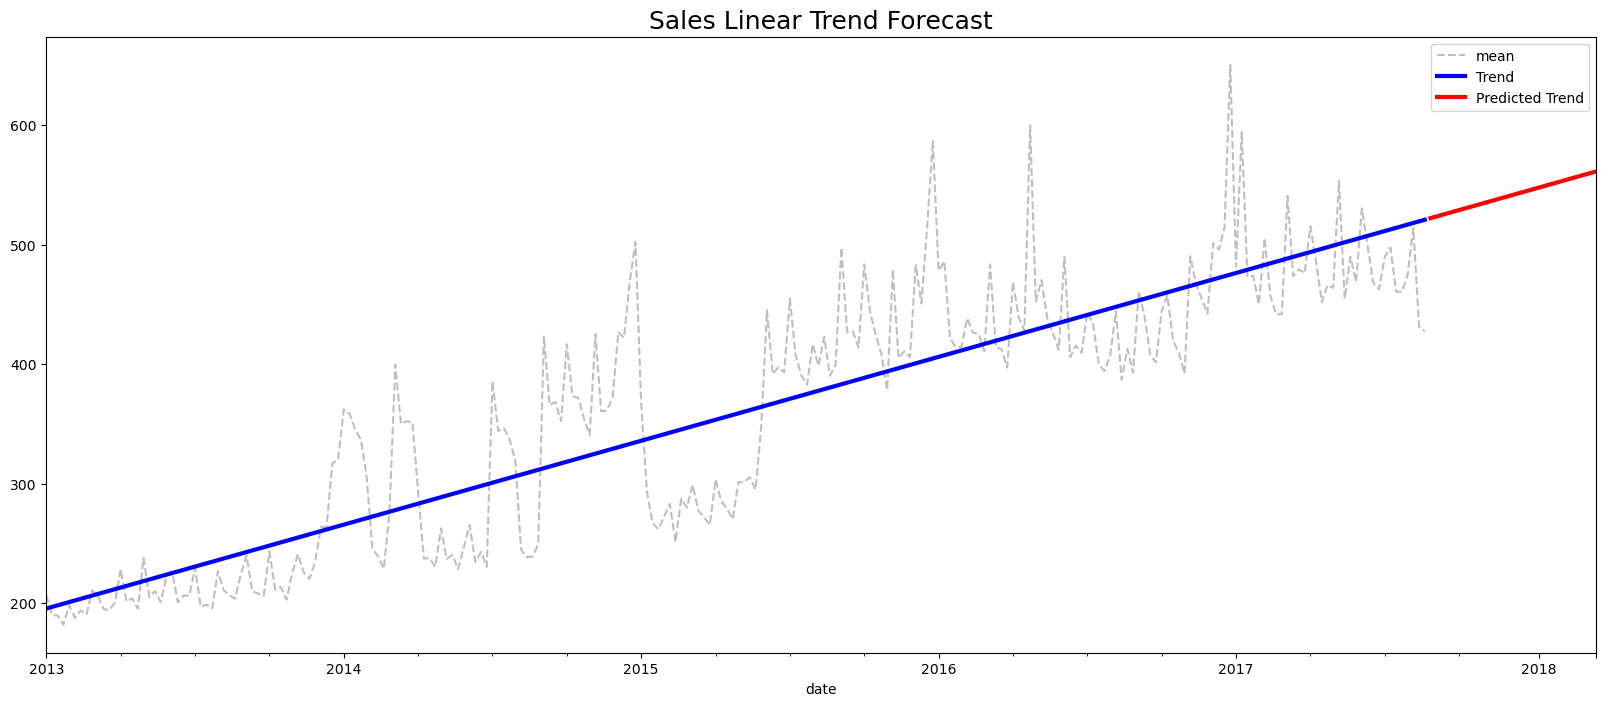

In [23]:
fig, axes = plt.subplots(figsize=(20,8))

steps = 30 
X2 = dp.out_of_sample(steps=30)
y2_fore = pd.Series(model.predict(X2), index=X2.index)
y2_fore.head()
ax2 = y1.plot(linestyle='dashed', label="mean", color="0.75")
ax2 = y1_pred.plot(linewidth=3, label="Trend", color='b')
ax2 = y2_fore.plot(linewidth=3, label="Predicted Trend", color='r')
ax2.set_title("Sales Linear Trend Forecast", fontsize=18)  
_ = ax2.legend()

Besides acting as a baseline or starting point for more sophisticated models, this trend model can be useful for a number of reasons as it shows us a rough forecast of the sales.

### Seasonality
Time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times. Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

In [24]:
def predict_seasonality(df, key, freq, col, ax1, title1):
    fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d") 
    df_grouped['date'].freq = freq # manually set the frequency of the index
    dp = DeterministicProcess(index=df_grouped['date'], 
                              constant=True, 
                              order=1, 
                              period=None, 
                              seasonal=True, 
                              additional_terms=[fourier], 
                              drop=True)
    dp.index.freq = freq # manually set the frequency of the index

    # 'in_sample' creates features for the dates given in the `index` argument
    X1 = dp.in_sample()
    y1 = df_grouped["mean"]  # the target
    y1.index = X1.index

    # The intercept is the same as the `const` feature from
    # DeterministicProcess. LinearRegression behaves badly with duplicated
    # features, so we need to be sure to exclude it here.
    model = LinearRegression(fit_intercept=False)
    model.fit(X1, y1)
    y1_pred = pd.Series(model.predict(X1), index=X1.index)
    X1_fore = dp.out_of_sample(steps=90)
    y1_fore = pd.Series(model.predict(X1_fore), index=X1_fore.index)
    
    ax1 = y1.plot(linestyle='dashed', style='.', label="init mean values", color="0.4", ax=ax1, use_index=True)
    ax1 = y1_pred.plot(linewidth=3, label="Seasonal", color='b', ax=ax1, use_index=True)
    ax1 = y1_fore.plot(linewidth=3, label="Seasonal Forecast", color='r', ax=ax1, use_index=True)
    ax1.set_title(title1, fontsize=18)  
    _ = ax1.legend()

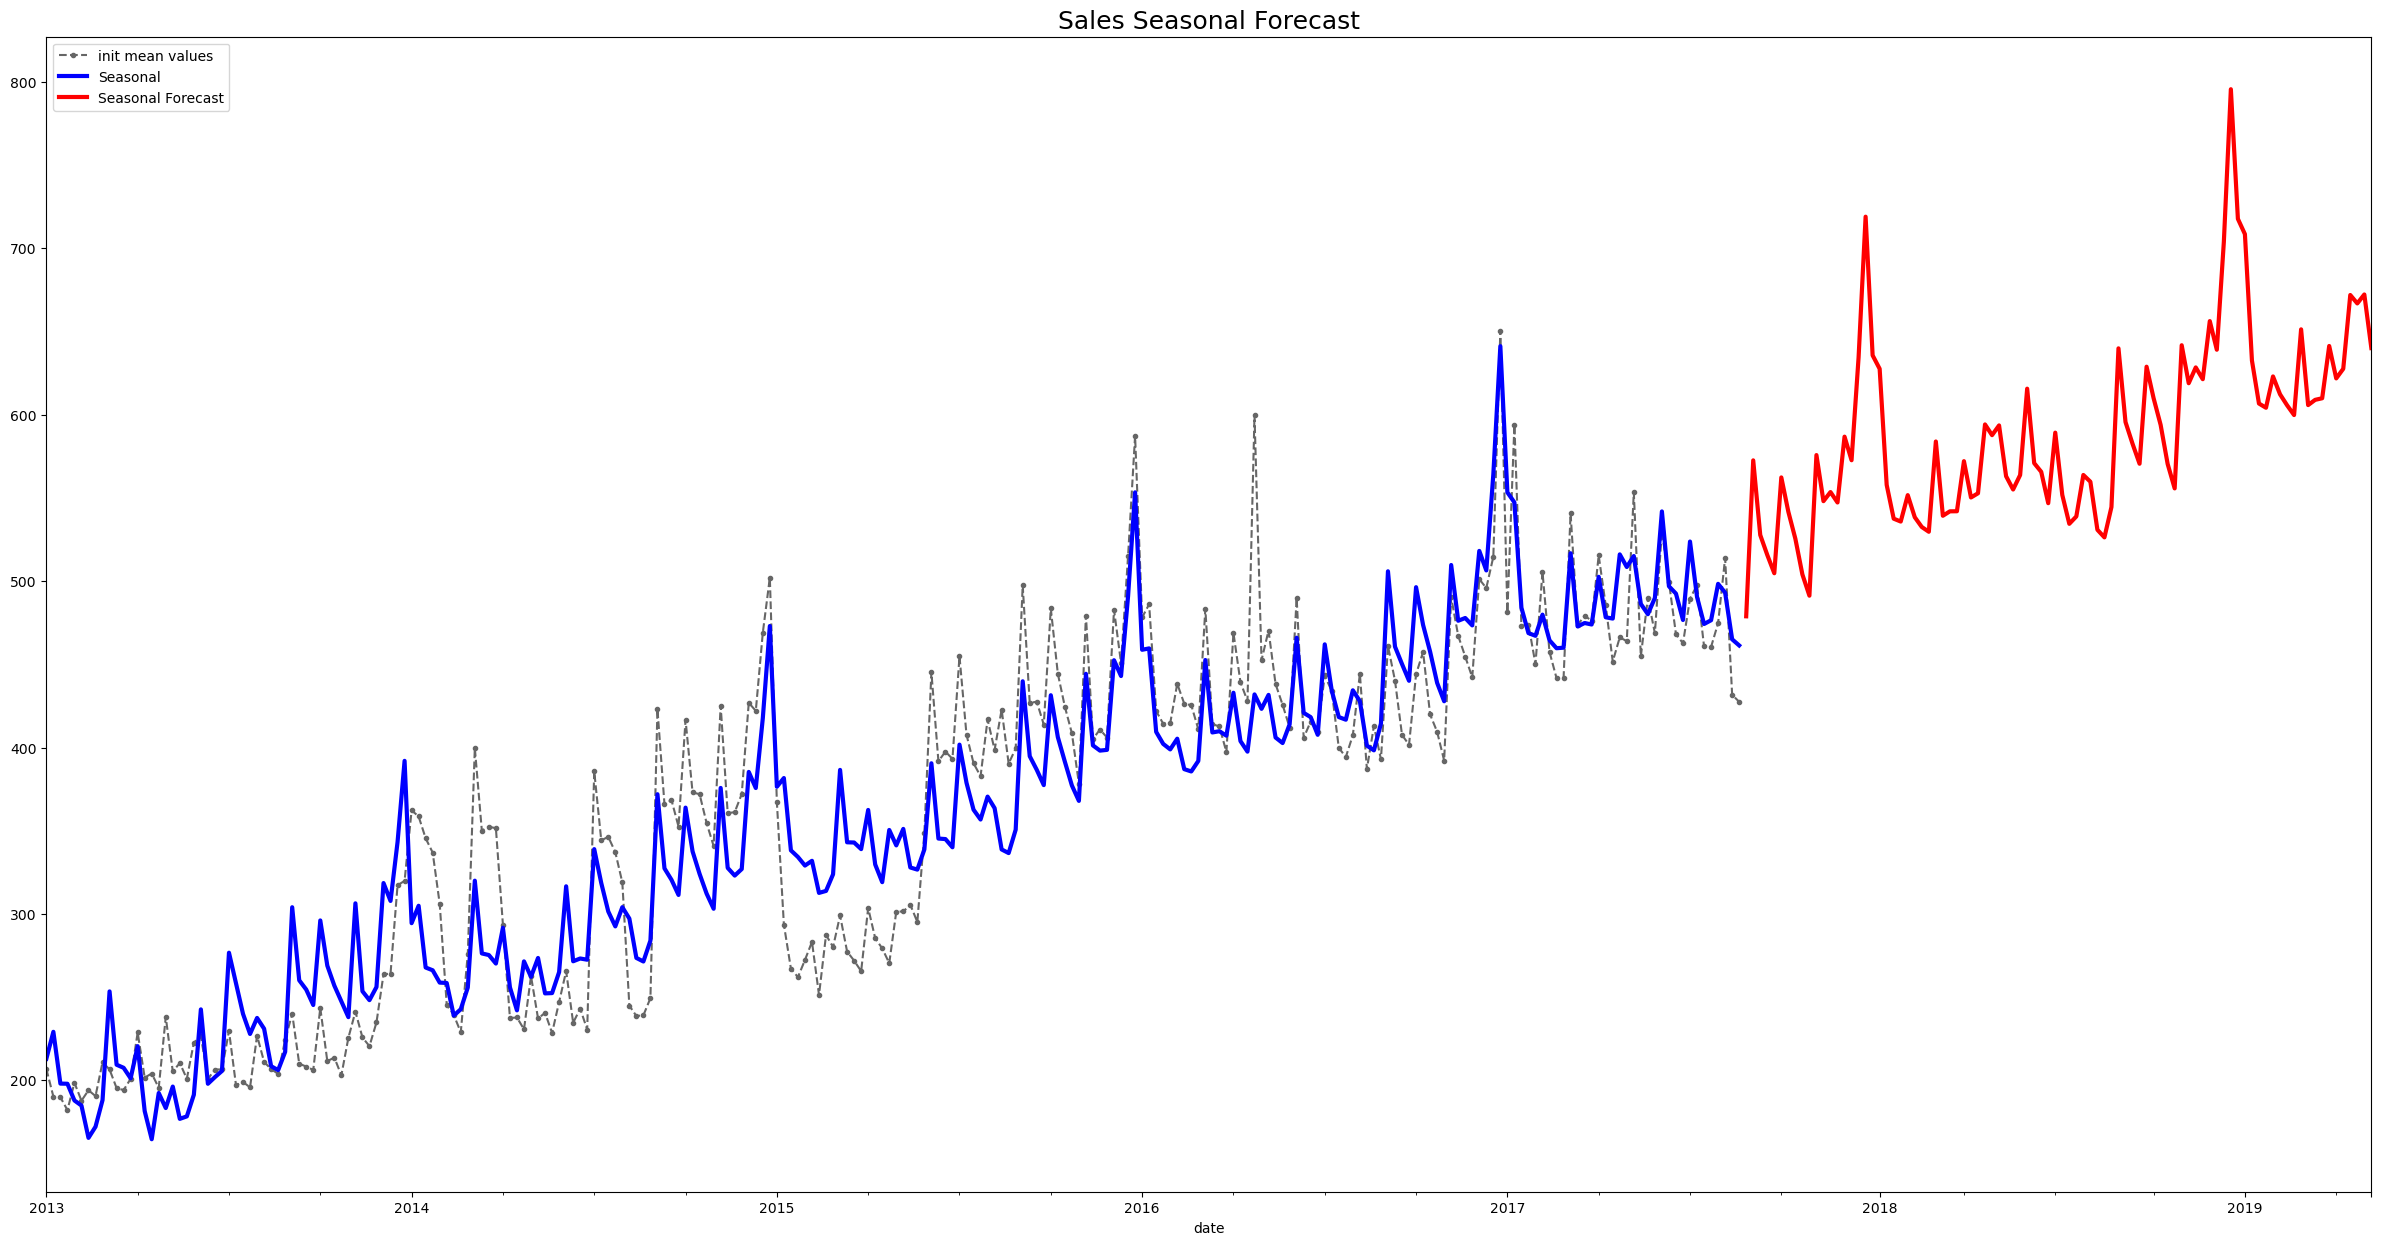

In [25]:
fig, axes = plt.subplots(figsize=(30,15))
predict_seasonality(train, 'date', 'W', 'sales', axes, "Sales Seasonal Forecast")
plt.show()

### machine learning forecasting?

In [26]:
store_sales = pd.read_csv(
    "data/store-sales-time-series-forecasting/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

C:\Users\xinmin\AppData\Local\Temp\ipykernel_16564\734778357.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


In [27]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

mag_sales = family_sales.loc(axis=1)[:, 'BEVERAGES']# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, 
        columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)
    
    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

from sklearn.preprocessing import LabelEncoder

# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()   # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])
# Label encoding for seasonality
X_2['day'] = X_2.index.day  # values are day of the month

family_sales

X_2

from xgboost import XGBRegressor
# YOUR CODE HERE: Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(
    model_1 = LinearRegression(),
    model_2 = XGBRegressor(),
)

# YOUR CODE HERE: Fit and predict
model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)



In [28]:
store_sales

sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]

In [29]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [30]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

In [31]:
def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, 
        columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)
    
    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

In [32]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

In [33]:
from sklearn.preprocessing import LabelEncoder

# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()   # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])
# Label encoding for seasonality
X_2['day'] = X_2.index.day  # values are day of the month

In [34]:
family_sales

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   
...               ...       ...        ...          ...       ...   
2017-08-11   8.166667  0.129630   6.500000  3502.055664  0.000000   
2017-08-12   7.462963  0.055556   6.833333  3376.259277  0.000000   
2017-08-13   8.907408  0.166667   8.018518  3747.296387  0.018519   
2017-08-14   5.407407  0.166667   6.240741  3237.629639  0.000000   
2017-08-15   6.240741  0.148148   6.277778  3162.462891  0.000000   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   
...                 ...         ...          ...          ...         ...   
2017-08-11   522.305298   16.111111  1031.148193   831.648132  345.934967   
2017-08-12   507.473114   15.722222  1072.870361   793.592590  290.553558   
2017-08-13   615.976990   10.074074  1143.648193   928.000000  325.801361   
2017-08-14   518.564026   11.000000  1019.111084   797.222229  271.532257   
2017-08-15   539.966553   11.055555  1082.851807   753.833313  276.582458   

            ... onpromotion                                        \
family      ...   MAGAZINES      MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                     
2017-01-01  ...         0.0   0.018519      0.111111     0.018519   
2017-01-02  ...         0.0   0.462963     10.592593     0.537037   
2017-01-03  ...         0.0   0.481481      9.722222     0.444444   
2017-01-04  ...         0.0   0.370370     12.037037     0.444444   
2017-01-05  ...         0.0   8.981481      5.666667     0.000000   
...         ...         ...        ...           ...          ...   
2017-08-11  ...         0.0  22.925926      9.000000     0.000000   
2017-08-12  ...         0.0   0.000000      8.703704     0.000000   
2017-08-13  ...         0.0   0.000000      9.240741     0.000000   
2017-08-14  ...         0.0   0.000000      8.722222     0.000000   
2017-08-15  ...         0.0   0.000000      8.814815     0.000000   

                                                                          \
family     PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS     PRODUCE   
date                                                                       
2017-01-01                0.000000   0.000000       0.037037    0.129630   
2017-01-02                0.000000   0.259259       1.166667    5.629630   
2017-01-03                0.000000   0.388889       1.351852   56.296296   
2017-01-04                0.000000   0.296296       5.444444  101.277778   
2017-01-05                0.000000   0.296296       0.907407    5.018519   
...                            ...        ...            ...         ...   
2017-08-11                0.000000  27.407407       0.537037    6.000000   
2017-08-12                0.018519   0.111111       0.277778    6.000000   
2017-08-13                0.000000   0.185185       0.222222    5.907407   
2017-08-14                0.000000   0.129630       0.148148    6.018519   
2017-08-15     

In [35]:
X_2

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1
...,...,...,...
2017-08-15,28,0.111111,15
2017-08-15,29,0.166667,15
2017-08-15,30,58.685185,15


In [36]:
from xgboost import XGBRegressor
# YOUR CODE HERE: Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(
    model_1 = LinearRegression(),
    model_2 = XGBRegressor(),
)

# YOUR CODE HERE: Fit and predict
model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

In [37]:
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

In [38]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

C:\Users\xinmin\AppData\Local\Temp\ipykernel_16564\2926216328.py:16: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
C:\Users\xinmin\AppData\Local\Temp\ipykernel_16564\2926216328.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)


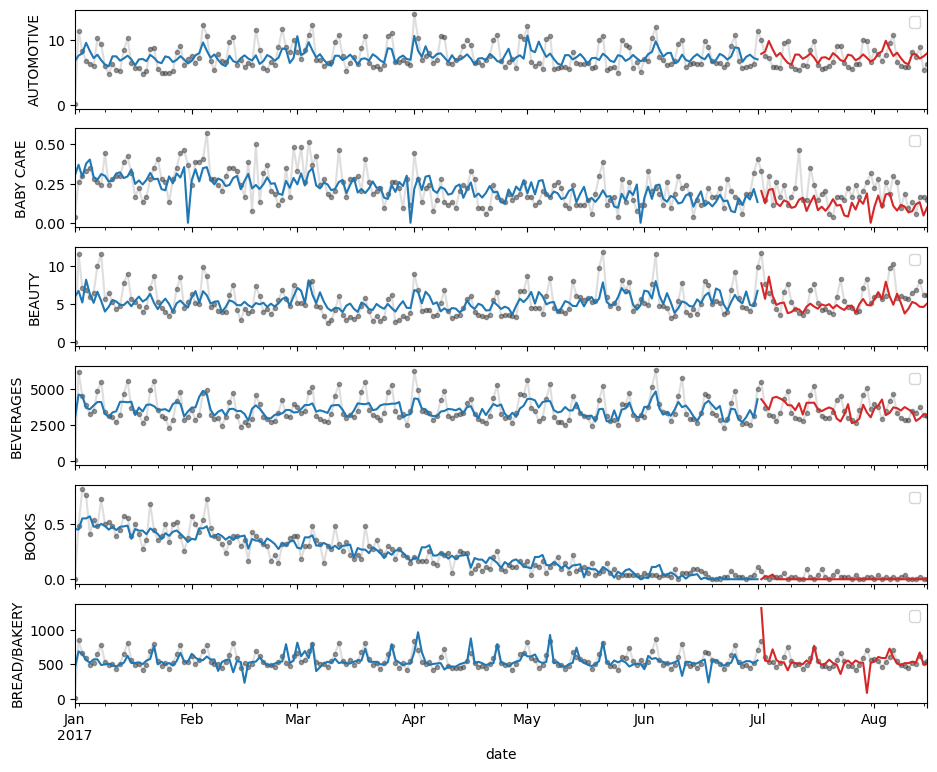

In [39]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

In [40]:
#family_sales.head()

test = pd.read_csv(
    "data/store-sales-time-series-forecasting/test.csv",
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

test.head()

C:\Users\xinmin\AppData\Local\Temp\ipykernel_16564\3988721562.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  test = pd.read_csv(


id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0

In [43]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [44]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [45]:
y = family_sales.loc[:, 'sales']

# make 4 lag features
X = make_lags(y, lags=5).dropna()

# make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [46]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y) 

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     6.018518    10.259259     9.388889   
           BABY CARE                      0.277778     0.259259     0.240741   
           BEAUTY                         6.518518    10.037037    11.611111   
           BEVERAGES                   3507.277832  4848.518555  5503.647949   
           BOOKS                          0.537037     0.481481     0.722222   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313995   
           PREPARED FOODS                84.698647    87.836800    88.735970   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.944445     4.777778     6.314815   
           BABY CARE                      0.444444     0.240741     0.277778   
           BEAUTY                         5.648148     6.500000     5.277778   
           BEVERAGES                   3448.203613  3171.740723  3046.870361   
           BOOKS                          0.500000     0.518519     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497009   416.454041   
           PREPARED FOODS                77.172997    91.886765   100.384964   
           PRODUCE                     1792.220947  2079.319336  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553965    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.388889     5.240741     8.500000   
           BABY CARE                      0.296296     0.296296     0.388889   
           BEAUTY                         4.370370     4.703704     7.777778   
           BEVERAGES                   2693.722168  3226.037109  4667.296387   
           BOOKS                          0.388889     0.444444     0.574074   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051758   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105957  2111.133301  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-06 AUTOMOTIVE                    10.259259     6.407407     5.685185   
           BABY CARE                      0.425926     0.314815     0.166667   
           BEAUTY                         9.037037     5.648148     5.351852   
           BEVERAGES                   5580.611328  3700.370361  3409.796387   
           BOOKS                          0.555556     0.388889     0.500000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270233   278.819885   468.857391   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076416  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

In [47]:
# init model
from sklearn.multioutput import RegressorChain
model = RegressorChain(base_estimator=XGBRegressor())

In [48]:
# train model
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=y.index,columns=y.columns).clip(0.0)
y_fit = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [51]:
# helpful function
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sb.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

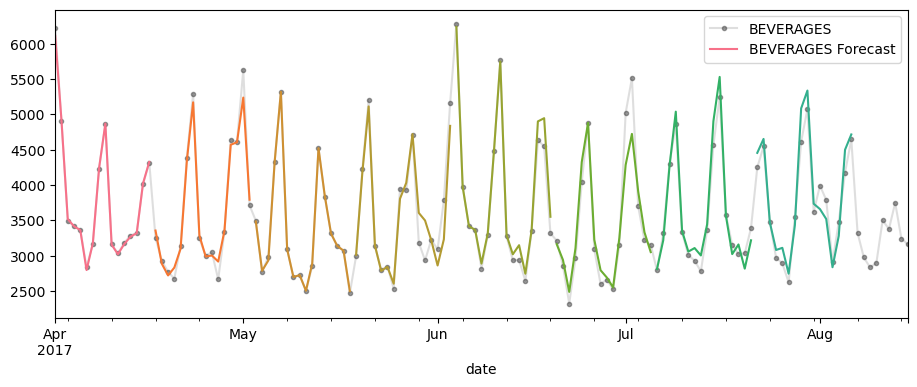

In [52]:
FAMILY = 'BEVERAGES'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(y, y_fit, squared=False)

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

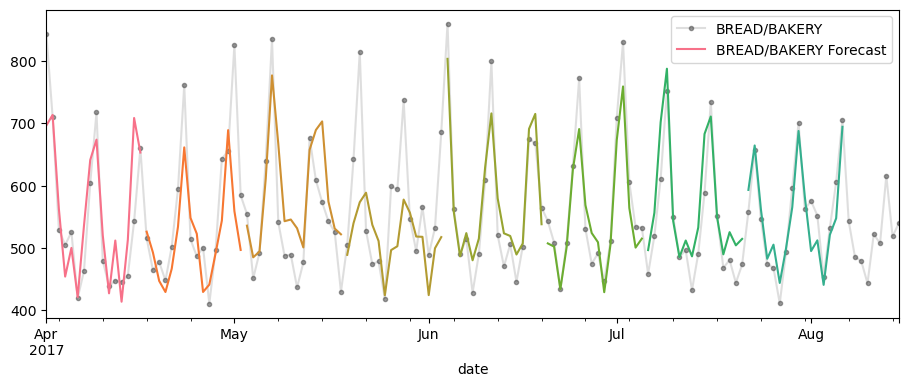

In [53]:
FAMILY = 'BREAD/BAKERY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(y, y_fit, squared=False)

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])